
## STOCHASTIC MODELING
MODULE 6 | LESSON 3


---

# **MULTI-ARMED BANDITS: Non-Stationary Case**

|  |  |
|:---|:---|
|**Reading Time** |  55 min |
|**Prior Knowledge** |Markov process, Optimization, Monte Carlo  |
|**Keywords** |Reinforcement learning, multi-armed bandits


---

*In this notebook, we are going to implement the learning methodologies of Lesson 1 and Lesson 2 in a non-stationary case. Make sure you understand this properly because it is going to lay the foundation for future work.*

In this third lesson, we are going to implement the learning methodologies of previous lessons in a non-stationary case. That is, rewards can change over time. Non-stationarity is the case most commonly encountered in reinforcement learning in general and finance in particular. Reinforcement learning involves a trade-off between exploration and exploitation.

We are going to fix an $\epsilon$-greedy policy that uses $\varepsilon=0.1$. Then, we are going to compare the performance of the updating policy that averages across the past history of rewards and the updating policy that uses a fixed parameter $\alpha=0.05$.

As in the application of Lesson 2, we compare the performance of both methods using the average reward by time step and the average frequency that the agent takes the optimal choice, also by each time step.

In [1]:
# LOAD LIBRARIES, PARAMETERS AND FUNCTIONS FROM LESSON 2

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, seed

# EXAMPLE OF A STATIONARY k-BANDIT PROBLEM
# Parameters
NK = 10
ITEMAX = 1000
EPSILON_M = [0.0, 0.1]
NEPISODES = 1000

seed(1234)

# Initialize actual distribution of each bandit
NMEANS = np.random.normal(loc=0.0, scale=1.0, size=NK)

print(NMEANS)


def optimal_action(qvalue, eps):
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:
                break
    elif action_hat[0].shape[0] > 1:
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):
            if randnum < (aa + 1) / action_hat[0].shape[0]:
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new

[ 0.47143516 -1.19097569  1.43270697 -0.3126519  -0.72058873  0.88716294
  0.85958841 -0.6365235   0.01569637 -2.24268495]


In [2]:
# EXAMPLE OF A NON-STATIONARY k-BANDIT PROBLEM


EPSILON = 0.1
ALPHA = 0.2

seed(1234)

reward_avg = np.zeros((ITEMAX, 2))
optimal_avg = np.zeros((ITEMAX, 2))

To make the problem non-stationary, we determine some random dates at which a "regime change" takes place, where the average reward is drawn again from a standard normal distribution. We set in advance a 1% probability that a change in regime takes place and store the "dates." By plotting the average reward in each regime, observe that the optimal action's reward is given by the upper envelope of the average rewards across actions (in bold blue in the graph below). <span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

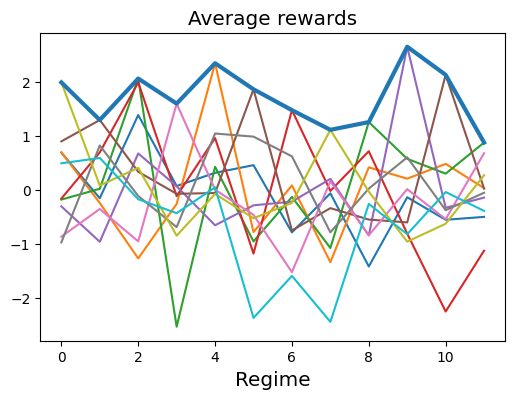

In [3]:
# Determine steps where the regime changes
PCHANGE = 0.01
tchanges = np.zeros(())
ntchanges = 0
for tt in range(ITEMAX):
    if rand() < PCHANGE:
        tchanges = np.append(tchanges, tt)
        ntchanges = ntchanges + 1

# Initialize actual distribution of each bandit across each regime change
# including the initial distribution
NMEANS = np.random.normal(loc=0.0, scale=1.0, size=(NK, ntchanges + 1))

# Plot the resulting mean rewards
for nn in range(NK):
    plt.plot(NMEANS[nn, :])

plt.plot(np.max(NMEANS, axis=0), linewidth=3.0, label="Max Reward")
# legend = plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel("Regime", fontsize="x-large")
plt.title("Average rewards", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.show()

Now we perform the action selection for the two types of updating schemes. Notice that, depending on the scheme, we pass a different argument "alpha_update" to the function "reward_update".

In [4]:
# We loop over two updating procedures: 1) averaging and 2) fixed alpha
for update in range(2):
    for run in range(NEPISODES):
        # Initialize q function and actions record
        qvalue = np.zeros((NK))
        nchoices = np.zeros((NK))
        change = 0
        for tt in range(ITEMAX):
            if tchanges[change] == tt:
                nmeans0 = NMEANS[:, change]
                change = min(change + 1, ntchanges)
            aa_opt = optimal_action(qvalue, EPSILON)
            reward = np.random.normal(loc=nmeans0[aa_opt], scale=1.0)
            nchoices[aa_opt] += 1
            alpha_update = 1 / nchoices[aa_opt] * (update == 0) + ALPHA * (update == 1)
            qvalue = reward_update(aa_opt, reward, qvalue, alpha_update)
            reward_avg[tt, update] += reward / NEPISODES
            optimal_avg[tt, update] += (aa_opt == np.argmax(nmeans0)) / NEPISODES

Let's verify the results.

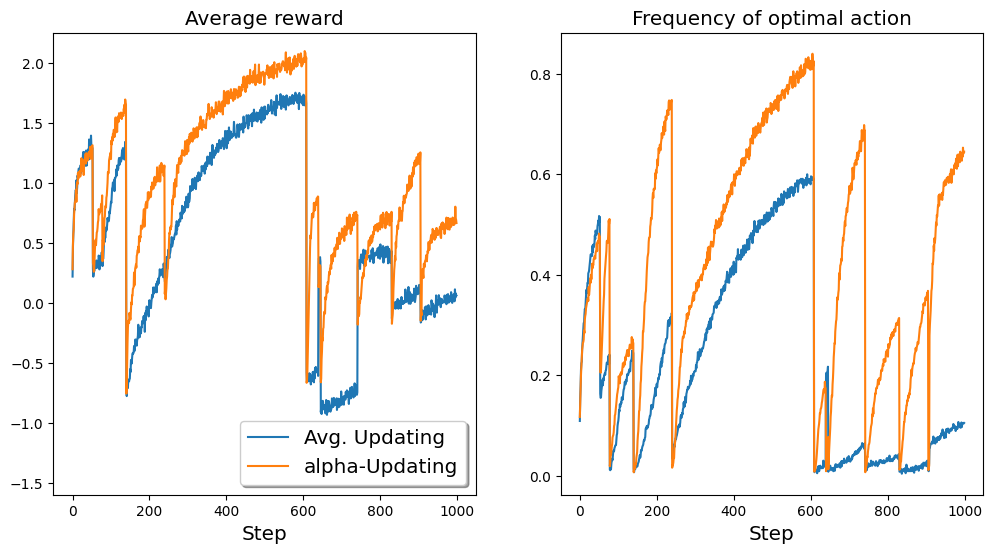

In [5]:
plt.subplot(1, 2, 1)
plt.plot(reward_avg[:, 0], label="Avg. Updating")
plt.plot(reward_avg[:, 1], label="alpha-Updating")
plt.axis([-50, 1050, -1.6, 2.25])
plt.xlabel("Step", fontsize="x-large")
plt.title("Average reward", fontsize="x-large")
legend = plt.legend(loc="lower right", shadow=True, fontsize="x-large")
plt.subplot(1, 2, 2)
plt.plot(optimal_avg[:, 0])
plt.plot(optimal_avg[:, 1])
plt.xlabel("Step", fontsize="x-large")
plt.title("Frequency of optimal action", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

In general, the policy that exploits a fixed parameter $\alpha$ to update the expected rewards behaves similar to a greedy action, which learns quickly after changes in regime. Thus, after regime changes, it tends to outperform the averaging method whose estimates are more dependent on the past. Nevertheless, when in periods of "stability" where regime changes do not happen, oftentimes, the averaging method tends to outperform the alternative.

The outperformance of one method over the other also depends on how the regime changes alter the ordering of actions in terms of expected rewards. When, after a regime change, the new optimal action already generated relatively high rewards, the averaging method would take it into account, minimally damaging its performance. In contrast, if the persistence in the ordering of actions is low, or even negative, the $\alpha$-updating method will be superior.

Still, even in the case where there is positive correlation in the ordering, the $\alpha$-updating method may perform better because it usually leads to greater exploration.

## **2. Conclusion**

In this lesson, we have worked through concepts of multi-armed bandits for non-stationary problems. In the next lesson, we will apply the model to investment strategies.

See you there!

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
